##### Copyright 2020 Qiyang Hu & Shao-Ching Huang

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/var/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting raw data

2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([source](https://github.com/CSSEGISandData/COVID-19))

In [0]:
import pandas as pd
import numpy as np

In [3]:
conf_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4


# Inspecting Infection Numbers

In [4]:
#today = conf_df.columns[len(conf_df.columns)-1]
today = conf_df.columns[-1]
today

'3/27/20'

In [0]:
#num_start_count = 140  # added into get_list() below

In [0]:
def get_list(col2search, val2search, conf_df, num_start_count=140):
#def get_list(col2search, val2search, conf_df):
  ts_list = conf_df[(conf_df[col2search] == val2search)]
  if ts_list.shape[0] > 1: # if the list has more than one row, we will do sum
    #ts_series = ts_list.sum(axis = 0, skipna = True)[4:]
    ts_series = ts_list.sum(axis = 0, skipna = True)[4:].astype(int)
    eff_dates = ts_series[ts_series > num_start_count].index
  else:
    ts_series = ts_list.drop(ts_list.columns[[0, 1, 2, 3]], axis=1).iloc[0]
    eff_dates = ts_series[ts_series > num_start_count].index
  start_date = eff_dates[0]
  ts_series.name = val2search  # name the series
  ts = ts_series[start_date:]
  return ts

## Extracting US data

In [7]:
ts_us = get_list('Country/Region', 'US', conf_df)
start_us = ts_us.index[0]
d_us = range(ts_us.count())
ts_us

3/4/20        149
3/5/20        217
3/6/20        262
3/7/20        402
3/8/20        518
3/9/20        583
3/10/20       959
3/11/20      1281
3/12/20      1663
3/13/20      2179
3/14/20      2727
3/15/20      3499
3/16/20      4632
3/17/20      6421
3/18/20      7783
3/19/20     13677
3/20/20     19100
3/21/20     25489
3/22/20     33276
3/23/20     43847
3/24/20     53740
3/25/20     65778
3/26/20     83836
3/27/20    101657
Name: US, dtype: int64

## Extracting California data

The dataset is stopped showing the California Data

In [8]:
ts_us_list = conf_df[(conf_df['Country/Region'] == 'US')]
ts_us_list.shape[0]

1

In [0]:
#ts_ca = get_list('Province/State', 'California', conf_df)
#start_ca = ts_ca.index[0]
#d_ca = range(ts_ca.count())
#ts_ca

## Extracting Italy data

In [10]:
ts_it = get_list('Country/Region', 'Italy', conf_df)
start_it = ts_it.index[0]
d_it = range(ts_it.count())
ts_it

2/23/20      155
2/24/20      229
2/25/20      322
2/26/20      453
2/27/20      655
2/28/20      888
2/29/20     1128
3/1/20      1694
3/2/20      2036
3/3/20      2502
3/4/20      3089
3/5/20      3858
3/6/20      4636
3/7/20      5883
3/8/20      7375
3/9/20      9172
3/10/20    10149
3/11/20    12462
3/12/20    12462
3/13/20    17660
3/14/20    21157
3/15/20    24747
3/16/20    27980
3/17/20    31506
3/18/20    35713
3/19/20    41035
3/20/20    47021
3/21/20    53578
3/22/20    59138
3/23/20    63927
3/24/20    69176
3/25/20    74386
3/26/20    80589
3/27/20    86498
Name: Italy, dtype: int64

## Extracting data for China (as reference)

In [11]:
ts_cn = get_list('Country/Region', 'China', conf_df)
start_cn = ts_cn.index[0]
d_cn = range(ts_cn.count())
ts_cn

1/22/20      548
1/23/20      643
1/24/20      920
1/25/20     1406
1/26/20     2075
           ...  
3/23/20    81498
3/24/20    81591
3/25/20    81661
3/26/20    81782
3/27/20    81897
Name: China, Length: 66, dtype: int64

## Curve fitting

In [0]:
from scipy.optimize import curve_fit

We use exponential function with the consideration of no signs of flattening emergence.

In [0]:
def func(x, a, b, c):
  return a * np.exp(b * x) + c

In [14]:
popt_us, pcov_us = curve_fit(func, d_us, ts_us)
popt_us

array([ 5.54081835e+02,  2.28478858e-01, -1.82118505e+03])

In [15]:
popt_it, pcov_it = curve_fit(func, d_it, ts_it)
popt_it

array([ 4.51310965e+03,  9.35468920e-02, -7.29644708e+03])

## Rough estimation for $R_0$

According to the SEIR model ([1](https://en.wikipedia.org/wiki/Basic_reproduction_number), [2](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)):

$R_0 = 1 + K (T_e + T_i) + K^2 T_e T_i$   

where

*   $K = \displaystyle \frac{d\ln(N)}{dt}$
*   $T_e$ is the duration of the exposed state 
*   $T_i$ is the duration of the latent infectious state


In [0]:
def R0(K, T_e, T_i):
  return 1 + K * (T_e + T_i) + K * K * T_e * T_i

According to the [paper](https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported), 97.5% of those who develop symptoms will do so within 11.5 days (CI, 8.2 to 15.6 days) of infection, thus we assume $T_i \approx 11.5$. Also assuming $T_e \approx 0.1$ 

In [17]:
R0_us = R0(popt_us[1], 11.5, 0.1)
R0_us

3.71038773043904

In [18]:
R0_it = R0(popt_it[1], 11.5, 0.1)
R0_it

2.09520762113513

## Plotting

In [0]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

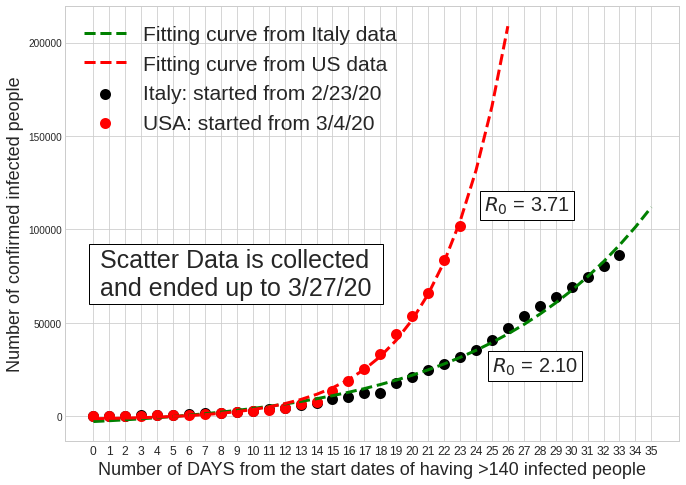

In [20]:
d_fn = range(ts_it.count()+2)
d_fn_us = range(ts_us.count()+3)

plt.figure(figsize=(11, 8))
plt.scatter(d_it, ts_it, color='black', linewidth=5, label='Italy: started from '+start_it)
plt.scatter(d_us, ts_us, color='red', linewidth=5, label='USA: started from '+start_us)
#plt.scatter(d_ca, ts_ca, color='blue', linewidth=5, label='CA: started from '+start_ca)
plt.plot(d_fn, func(d_fn, *popt_it), 'g--', linewidth=3, label="Fitting curve from Italy data")
plt.plot(d_fn_us, func(d_fn_us, *popt_us), 'r--', linewidth=3, label="Fitting curve from US data")
#plt.scatter(d_cn, ts_cn, color='yellow', label='China: started from Jan 22')

plt.xticks(d_fn, fontsize="12")
plt.xlabel("Number of DAYS from the start dates of having >140 infected people", fontsize='18')
plt.ylabel("Number of confirmed infected people", fontsize='18')
plt.legend(loc='upper left', fontsize=21)
plt.text(0, 65000, ' Scatter Data is collected \n and ended up to '+today+" ", fontsize=25, bbox=dict(facecolor='white', alpha=1))
plt.text(24.5, 110000, '$R_0$ = '+"{:.2f}".format(R0_us), fontsize=20, bbox=dict(facecolor='white', alpha=1))
plt.text(25, 24000, '$R_0$ = '+"{:.2f}".format(R0_it), fontsize=20, bbox=dict(facecolor='white', alpha=1))
plt.show()

## Normalized by Population

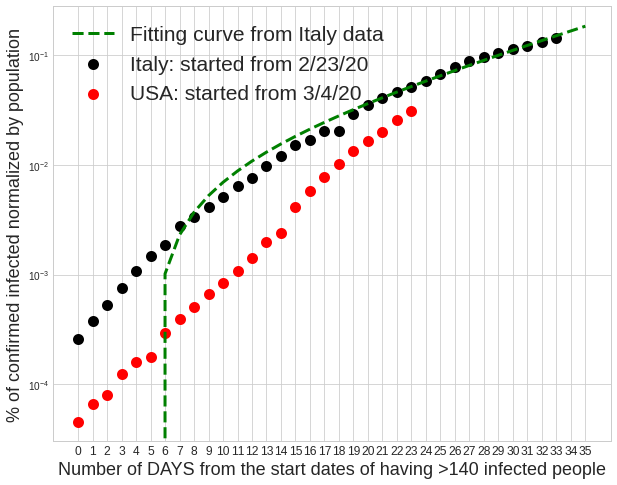

In [21]:
# population in MILLION from crude google search
us_population =  327.2  * 10**6
it_population =   60.48 * 10**6
#ca_population =   39.56 * 10**6
cn_population = 1386    * 10**6

d_fn = range(ts_it.count()+2)

plt.figure(figsize=(10, 8))
plt.scatter(d_it, 100*ts_it/it_population, color='black', linewidth=5, label='Italy: started from '+start_it)
plt.scatter(d_us, 100*ts_us/us_population, color='red', linewidth=5, label='USA: started from '+start_us)
#plt.scatter(d_ca, 100*ts_ca/ca_population, color='blue', linewidth=5, label='California: started from '+start_ca)
plt.plot(d_fn, 100*func(d_fn, *popt_it)/it_population, 'g--', linewidth=3, label="Fitting curve from Italy data")
#plt.scatter(d_cn, ts_cn, color='yellow', label='China: started from Jan 22')

plt.xticks(d_fn, fontsize="12")
plt.xlabel("Number of DAYS from the start dates of having >140 infected people", fontsize='18')
plt.ylabel("% of confirmed infected normalized by population", fontsize='18')
plt.legend(loc='upper left', fontsize=21)
#plt.text(0.5, 22000, ' Scatter Data is collected \n and ended up to '+today+" ", fontsize=27, bbox=dict(facecolor='white', alpha=1))
plt.yscale('log')

# Inspecting Lagged Days

In [22]:
data = [{'Country': "Italy",          'Population': 60461826}, 
        {'Country':"Germany",         'Population': 83783942},
        {'Country':"Sweden",          'Population': 10099265},
        {'Country':"Spain",           'Population': 46754778},
        {'Country':"Belgium",         'Population': 11589623},
        {'Country':"Switzerland",     'Population': 8654622},
        {'Country':"United Kingdom",  'Population': 67886011},
        {'Country':"US",              'Population': 331002651},
        ]
df = pd.DataFrame(data)
df

,Country,Population
0,Italy,60461826
1,Germany,83783942
2,Sweden,10099265
3,Spain,46754778
4,Belgium,11589623
5,Switzerland,8654622
6,United Kingdom,67886011
7,US,331002651


In [23]:
# UN population data (unit: thousand)

un_pop = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx', skiprows=16)

def un_population(country, year='2020'):
  n = un_pop[ un_pop['Region, subregion, country or area *']==country].iloc[0][year] * 1000
  return int(n)

data_un = [{'Country': "Italy",          'Population': un_population('Italy')}, 
        {'Country':"Germany",         'Population': un_population('Germany')},
        {'Country':"Sweden",          'Population': un_population('Sweden')},
        {'Country':"Spain",           'Population': un_population('Spain')},
        {'Country':"Belgium",         'Population': un_population('Belgium')},
        {'Country':"Switzerland",     'Population': un_population('Switzerland')},
        {'Country':"United Kingdom",  'Population': un_population('United Kingdom')},
        {'Country':"US",              'Population': un_population('United States of America')},
       ]
df = pd.DataFrame(data_un)
df

,Country,Population
0,Italy,60461828
1,Germany,83783945
2,Sweden,10099270
3,Spain,46754783
4,Belgium,11589616
5,Switzerland,8654618
6,United Kingdom,67886004
7,US,331002647


In [24]:
days = []
infect_latest = []
infect_latest_norm = []
for index, row in df.iterrows():
  country = row['Country']
  population = row['Population']
  ts = get_list('Country/Region', country, conf_df)
  infect_latest.append(ts[-1])
  infect_latest_norm.append(ts[-1]/population)
  days.append( ts.count() )
d_max = max(days)
df['Lagged_days'] = d_max - days
df['Latest_infections'] = infect_latest
df['Normalized_Latest_infections'] = infect_latest_norm
df

,Country,Population,Lagged_days,Latest_infections,Normalized_Latest_infections
0,Italy,60461828,0,86498,0.001431
1,Germany,83783945,8,50871,0.000607
2,Sweden,10099270,13,3069,0.000304
3,Spain,46754783,9,65719,0.001406
4,Belgium,11589616,13,7284,0.000628
5,Switzerland,8654618,12,12928,0.001494
6,United Kingdom,67886004,12,14745,0.000217
7,US,331002647,10,101657,0.000307
